In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

MEASUREMENTS_PER_SAMPLE = 50
CSV_FILE_PATH = 'gyroscope_data_updated.csv'

def alineData(df):
    def alineDateWithLabel(label, df):
        lable_data = df[df['activity_type'] == label]
        return lable_data[0:lable_data.shape[0] - lable_data.shape[0] % MEASUREMENTS_PER_SAMPLE]
    
    return pd.concat([alineDateWithLabel(label, df) for label in df['activity_type'].unique()])

df = alineData(pd.read_csv(CSV_FILE_PATH))
samples_number = df.shape[0] // MEASUREMENTS_PER_SAMPLE

def prepareTargets(df):
    df = df[df.columns[-1:len(df.columns)]]
    
    def prepareTarget(sample_index):
        sample_start_index = sample_index * MEASUREMENTS_PER_SAMPLE
        sample_end_index = (sample_index + 1) * MEASUREMENTS_PER_SAMPLE
        
        targets = df[sample_start_index:sample_end_index]['activity_type'].unique()
        
        if(targets.size > 1):
            raise ValueError('Sample can not have more then one target')
        
        return targets[0] 
    
    return LabelBinarizer().fit_transform(np.array([prepareTarget(index) for index in range(0, samples_number)]))

def prepareSamples(df):
    return df[df.columns[0:-1]].values.reshape((samples_number, MEASUREMENTS_PER_SAMPLE, 6))

samples = prepareSamples(df)
targets = prepareTargets(df)

print(samples.shape)
print(targets.shape)

(1532, 50, 6)
(1532, 5)


In [3]:
def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = shuffleSamplesAndTargets(samples, targets)

In [4]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(919, 50, 6)
(919, 5)
(306, 50, 6)
(306, 5)
(306, 50, 6)
(306, 5)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.55))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(test_labels.shape[-1], activation='softmax'))

In [6]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
              loss='mse',
              metrics=['accuracy'])

In [7]:
PATH_TO_BEST_MODEL = 'models/best_model.hdf5'

callbacks = [
    keras.callbacks.ModelCheckpoint(PATH_TO_BEST_MODEL, 
                                    monitor='val_acc', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1)
]

history = model.fit(train_data,
                    train_labels,
                    epochs=1000,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_data, val_labels))

Train on 919 samples, validate on 306 samples
Epoch 1/1000
919/919 [==============================] - 0s 366us/step - loss: 0.2716 - acc: 0.2905 - val_loss: 0.2351 - val_acc: 0.3954
Epoch 2/1000
919/919 [==============================] - 0s 89us/step - loss: 0.2684 - acc: 0.2971 - val_loss: 0.2326 - val_acc: 0.4085
Epoch 3/1000
919/919 [==============================] - 0s 85us/step - loss: 0.2578 - acc: 0.3308 - val_loss: 0.2328 - val_acc: 0.4085
Epoch 4/1000
919/919 [==============================] - 0s 91us/step - loss: 0.2521 - acc: 0.3449 - val_loss: 0.2324 - val_acc: 0.4085
Epoch 5/1000
919/919 [==============================] - 0s 96us/step - loss: 0.2499 - acc: 0.3504 - val_loss: 0.2378 - val_acc: 0.3987
Epoch 6/1000
919/919 [==============================] - 0s 102us/step - loss: 0.2475 - acc: 0.3536 - val_loss: 0.2356 - val_acc: 0.4020
Epoch 7/1000
919/919 [==============================] - 0s 105us/step - loss: 0.2440 - acc: 0.3645 - val_loss: 0.2268 - val_acc: 0.4248
Epoch 

Epoch 61/1000
919/919 [==============================] - 0s 107us/step - loss: 0.1400 - acc: 0.5909 - val_loss: 0.1257 - val_acc: 0.6144
Epoch 62/1000
919/919 [==============================] - 0s 113us/step - loss: 0.1294 - acc: 0.6115 - val_loss: 0.1264 - val_acc: 0.6242
Epoch 63/1000
919/919 [==============================] - 0s 94us/step - loss: 0.1245 - acc: 0.6094 - val_loss: 0.1201 - val_acc: 0.6275
Epoch 64/1000
919/919 [==============================] - 0s 80us/step - loss: 0.1303 - acc: 0.5963 - val_loss: 0.1155 - val_acc: 0.6373
Epoch 65/1000
919/919 [==============================] - 0s 89us/step - loss: 0.1229 - acc: 0.6181 - val_loss: 0.1178 - val_acc: 0.6438
Epoch 66/1000
919/919 [==============================] - 0s 81us/step - loss: 0.1241 - acc: 0.6094 - val_loss: 0.1168 - val_acc: 0.6307
Epoch 67/1000
919/919 [==============================] - 0s 88us/step - loss: 0.1233 - acc: 0.6083 - val_loss: 0.1139 - val_acc: 0.6405
Epoch 68/1000
919/919 [=======================

919/919 [==============================] - 0s 81us/step - loss: 0.0703 - acc: 0.7639 - val_loss: 0.0601 - val_acc: 0.8333
Epoch 122/1000
919/919 [==============================] - 0s 88us/step - loss: 0.0738 - acc: 0.7508 - val_loss: 0.0629 - val_acc: 0.8268
Epoch 123/1000
919/919 [==============================] - 0s 89us/step - loss: 0.0742 - acc: 0.7617 - val_loss: 0.0622 - val_acc: 0.8039
Epoch 124/1000
919/919 [==============================] - 0s 89us/step - loss: 0.0673 - acc: 0.7824 - val_loss: 0.0563 - val_acc: 0.8268
Epoch 125/1000
919/919 [==============================] - 0s 88us/step - loss: 0.0769 - acc: 0.7388 - val_loss: 0.0603 - val_acc: 0.8170
Epoch 126/1000
919/919 [==============================] - 0s 84us/step - loss: 0.0720 - acc: 0.7661 - val_loss: 0.0572 - val_acc: 0.8366
Epoch 127/1000
919/919 [==============================] - 0s 84us/step - loss: 0.0668 - acc: 0.7867 - val_loss: 0.0567 - val_acc: 0.8366
Epoch 128/1000
919/919 [==============================] 

Epoch 181/1000
919/919 [==============================] - 0s 100us/step - loss: 0.0509 - acc: 0.8433 - val_loss: 0.0453 - val_acc: 0.8562
Epoch 182/1000
919/919 [==============================] - 0s 97us/step - loss: 0.0524 - acc: 0.8324 - val_loss: 0.0442 - val_acc: 0.8660
Epoch 183/1000
919/919 [==============================] - 0s 97us/step - loss: 0.0520 - acc: 0.8237 - val_loss: 0.0411 - val_acc: 0.8824
Epoch 184/1000
919/919 [==============================] - 0s 95us/step - loss: 0.0525 - acc: 0.8248 - val_loss: 0.0484 - val_acc: 0.8529
Epoch 185/1000
919/919 [==============================] - 0s 100us/step - loss: 0.0495 - acc: 0.8368 - val_loss: 0.0476 - val_acc: 0.8497
Epoch 186/1000
919/919 [==============================] - 0s 101us/step - loss: 0.0529 - acc: 0.8281 - val_loss: 0.0485 - val_acc: 0.8497
Epoch 187/1000
919/919 [==============================] - 0s 107us/step - loss: 0.0598 - acc: 0.7911 - val_loss: 0.0472 - val_acc: 0.8562
Epoch 188/1000
919/919 [=============

Epoch 241/1000
919/919 [==============================] - 0s 89us/step - loss: 0.0442 - acc: 0.8531 - val_loss: 0.0409 - val_acc: 0.8725
Epoch 242/1000
919/919 [==============================] - 0s 86us/step - loss: 0.0436 - acc: 0.8553 - val_loss: 0.0420 - val_acc: 0.8660
Epoch 243/1000
919/919 [==============================] - 0s 88us/step - loss: 0.0423 - acc: 0.8662 - val_loss: 0.0417 - val_acc: 0.8824
Epoch 244/1000
919/919 [==============================] - 0s 90us/step - loss: 0.0450 - acc: 0.8575 - val_loss: 0.0405 - val_acc: 0.8693
Epoch 245/1000
919/919 [==============================] - 0s 91us/step - loss: 0.0416 - acc: 0.8716 - val_loss: 0.0415 - val_acc: 0.8627
Epoch 246/1000
919/919 [==============================] - 0s 87us/step - loss: 0.0399 - acc: 0.8629 - val_loss: 0.0445 - val_acc: 0.8562
Epoch 247/1000
919/919 [==============================] - 0s 81us/step - loss: 0.0424 - acc: 0.8716 - val_loss: 0.0400 - val_acc: 0.8725
Epoch 248/1000
919/919 [=================

Epoch 301/1000
919/919 [==============================] - 0s 103us/step - loss: 0.0409 - acc: 0.8651 - val_loss: 0.0419 - val_acc: 0.8693
Epoch 302/1000
919/919 [==============================] - 0s 95us/step - loss: 0.0360 - acc: 0.8879 - val_loss: 0.0396 - val_acc: 0.8824
Epoch 303/1000
919/919 [==============================] - 0s 90us/step - loss: 0.0408 - acc: 0.8694 - val_loss: 0.0461 - val_acc: 0.8627
Epoch 304/1000
919/919 [==============================] - 0s 91us/step - loss: 0.0365 - acc: 0.8847 - val_loss: 0.0417 - val_acc: 0.8725
Epoch 305/1000
919/919 [==============================] - 0s 94us/step - loss: 0.0368 - acc: 0.8803 - val_loss: 0.0431 - val_acc: 0.8725
Epoch 306/1000
919/919 [==============================] - 0s 99us/step - loss: 0.0345 - acc: 0.8890 - val_loss: 0.0429 - val_acc: 0.8693
Epoch 307/1000
919/919 [==============================] - 0s 98us/step - loss: 0.0329 - acc: 0.8977 - val_loss: 0.0420 - val_acc: 0.8693
Epoch 308/1000
919/919 [================

Epoch 361/1000
919/919 [==============================] - 0s 93us/step - loss: 0.0334 - acc: 0.8934 - val_loss: 0.0370 - val_acc: 0.8856
Epoch 362/1000
919/919 [==============================] - 0s 94us/step - loss: 0.0344 - acc: 0.8923 - val_loss: 0.0396 - val_acc: 0.8725
Epoch 363/1000
919/919 [==============================] - 0s 94us/step - loss: 0.0312 - acc: 0.8955 - val_loss: 0.0431 - val_acc: 0.8693
Epoch 364/1000
919/919 [==============================] - 0s 96us/step - loss: 0.0296 - acc: 0.9042 - val_loss: 0.0367 - val_acc: 0.8791
Epoch 365/1000
919/919 [==============================] - 0s 100us/step - loss: 0.0325 - acc: 0.8945 - val_loss: 0.0387 - val_acc: 0.8758
Epoch 366/1000
919/919 [==============================] - 0s 93us/step - loss: 0.0324 - acc: 0.8999 - val_loss: 0.0388 - val_acc: 0.8693
Epoch 367/1000
919/919 [==============================] - 0s 97us/step - loss: 0.0312 - acc: 0.8945 - val_loss: 0.0375 - val_acc: 0.8824
Epoch 368/1000
919/919 [================

919/919 [==============================] - 0s 98us/step - loss: 0.0259 - acc: 0.9217 - val_loss: 0.0395 - val_acc: 0.8725
Epoch 421/1000
919/919 [==============================] - 0s 92us/step - loss: 0.0290 - acc: 0.9032 - val_loss: 0.0378 - val_acc: 0.8889
Epoch 422/1000
919/919 [==============================] - 0s 100us/step - loss: 0.0269 - acc: 0.9151 - val_loss: 0.0367 - val_acc: 0.8824
Epoch 423/1000
919/919 [==============================] - 0s 98us/step - loss: 0.0284 - acc: 0.9053 - val_loss: 0.0371 - val_acc: 0.8856
Epoch 424/1000
919/919 [==============================] - 0s 97us/step - loss: 0.0289 - acc: 0.9119 - val_loss: 0.0396 - val_acc: 0.8758
Epoch 425/1000
919/919 [==============================] - 0s 100us/step - loss: 0.0282 - acc: 0.9097 - val_loss: 0.0373 - val_acc: 0.8758
Epoch 426/1000
919/919 [==============================] - 0s 100us/step - loss: 0.0265 - acc: 0.9162 - val_loss: 0.0396 - val_acc: 0.8824
Epoch 427/1000
919/919 [=============================

Epoch 480/1000
919/919 [==============================] - 0s 92us/step - loss: 0.0240 - acc: 0.9336 - val_loss: 0.0394 - val_acc: 0.8693
Epoch 481/1000
919/919 [==============================] - 0s 90us/step - loss: 0.0262 - acc: 0.9238 - val_loss: 0.0338 - val_acc: 0.8987
Epoch 482/1000
919/919 [==============================] - 0s 92us/step - loss: 0.0279 - acc: 0.9108 - val_loss: 0.0385 - val_acc: 0.8791
Epoch 483/1000
919/919 [==============================] - 0s 94us/step - loss: 0.0234 - acc: 0.9206 - val_loss: 0.0391 - val_acc: 0.8824
Epoch 484/1000
919/919 [==============================] - 0s 102us/step - loss: 0.0241 - acc: 0.9271 - val_loss: 0.0369 - val_acc: 0.8954
Epoch 485/1000
919/919 [==============================] - 0s 104us/step - loss: 0.0231 - acc: 0.9260 - val_loss: 0.0331 - val_acc: 0.8889
Epoch 486/1000
919/919 [==============================] - 0s 94us/step - loss: 0.0231 - acc: 0.9271 - val_loss: 0.0348 - val_acc: 0.8954
Epoch 487/1000
919/919 [===============

919/919 [==============================] - 0s 104us/step - loss: 0.0258 - acc: 0.9206 - val_loss: 0.0344 - val_acc: 0.8922
Epoch 540/1000
919/919 [==============================] - 0s 98us/step - loss: 0.0278 - acc: 0.9129 - val_loss: 0.0344 - val_acc: 0.8889
Epoch 541/1000
919/919 [==============================] - 0s 103us/step - loss: 0.0229 - acc: 0.9304 - val_loss: 0.0341 - val_acc: 0.8954
Epoch 542/1000
919/919 [==============================] - 0s 105us/step - loss: 0.0241 - acc: 0.9260 - val_loss: 0.0362 - val_acc: 0.8954
Epoch 543/1000
919/919 [==============================] - 0s 98us/step - loss: 0.0213 - acc: 0.9314 - val_loss: 0.0349 - val_acc: 0.8856
Epoch 544/1000
919/919 [==============================] - 0s 98us/step - loss: 0.0260 - acc: 0.9227 - val_loss: 0.0427 - val_acc: 0.8693
Epoch 545/1000
919/919 [==============================] - 0s 99us/step - loss: 0.0238 - acc: 0.9217 - val_loss: 0.0456 - val_acc: 0.8497
Epoch 546/1000
919/919 [=============================

919/919 [==============================] - 0s 92us/step - loss: 0.0225 - acc: 0.9347 - val_loss: 0.0348 - val_acc: 0.8954
Epoch 599/1000
919/919 [==============================] - 0s 119us/step - loss: 0.0213 - acc: 0.9304 - val_loss: 0.0387 - val_acc: 0.8791
Epoch 600/1000
919/919 [==============================] - 0s 102us/step - loss: 0.0208 - acc: 0.9391 - val_loss: 0.0388 - val_acc: 0.8824
Epoch 601/1000
919/919 [==============================] - 0s 99us/step - loss: 0.0211 - acc: 0.9358 - val_loss: 0.0389 - val_acc: 0.8856
Epoch 602/1000
919/919 [==============================] - 0s 94us/step - loss: 0.0232 - acc: 0.9238 - val_loss: 0.0383 - val_acc: 0.8758
Epoch 603/1000
919/919 [==============================] - 0s 96us/step - loss: 0.0207 - acc: 0.9336 - val_loss: 0.0398 - val_acc: 0.8824
Epoch 604/1000
919/919 [==============================] - 0s 94us/step - loss: 0.0256 - acc: 0.9184 - val_loss: 0.0365 - val_acc: 0.8856
Epoch 605/1000
919/919 [==============================

919/919 [==============================] - 0s 98us/step - loss: 0.0182 - acc: 0.9369 - val_loss: 0.0369 - val_acc: 0.8889
Epoch 658/1000
919/919 [==============================] - 0s 101us/step - loss: 0.0191 - acc: 0.9391 - val_loss: 0.0332 - val_acc: 0.9020
Epoch 659/1000
919/919 [==============================] - 0s 101us/step - loss: 0.0196 - acc: 0.9402 - val_loss: 0.0477 - val_acc: 0.8529
Epoch 660/1000
919/919 [==============================] - 0s 104us/step - loss: 0.0191 - acc: 0.9380 - val_loss: 0.0366 - val_acc: 0.8856
Epoch 661/1000
919/919 [==============================] - 0s 98us/step - loss: 0.0215 - acc: 0.9380 - val_loss: 0.0357 - val_acc: 0.8856
Epoch 662/1000
919/919 [==============================] - 0s 94us/step - loss: 0.0202 - acc: 0.9456 - val_loss: 0.0358 - val_acc: 0.8889
Epoch 663/1000
919/919 [==============================] - 0s 93us/step - loss: 0.0190 - acc: 0.9445 - val_loss: 0.0350 - val_acc: 0.8889
Epoch 664/1000
919/919 [=============================

919/919 [==============================] - 0s 117us/step - loss: 0.0217 - acc: 0.9347 - val_loss: 0.0357 - val_acc: 0.8954
Epoch 717/1000
919/919 [==============================] - 0s 108us/step - loss: 0.0193 - acc: 0.9467 - val_loss: 0.0358 - val_acc: 0.9020
Epoch 718/1000
919/919 [==============================] - 0s 100us/step - loss: 0.0201 - acc: 0.9369 - val_loss: 0.0385 - val_acc: 0.8889
Epoch 719/1000
919/919 [==============================] - 0s 108us/step - loss: 0.0201 - acc: 0.9369 - val_loss: 0.0360 - val_acc: 0.8922
Epoch 720/1000
919/919 [==============================] - 0s 101us/step - loss: 0.0241 - acc: 0.9238 - val_loss: 0.0331 - val_acc: 0.9020
Epoch 721/1000
919/919 [==============================] - 0s 101us/step - loss: 0.0168 - acc: 0.9499 - val_loss: 0.0350 - val_acc: 0.8954
Epoch 722/1000
919/919 [==============================] - 0s 101us/step - loss: 0.0221 - acc: 0.9314 - val_loss: 0.0314 - val_acc: 0.9118
Epoch 723/1000
919/919 [=========================

919/919 [==============================] - 0s 100us/step - loss: 0.0159 - acc: 0.9510 - val_loss: 0.0332 - val_acc: 0.9052
Epoch 776/1000
919/919 [==============================] - 0s 103us/step - loss: 0.0218 - acc: 0.9325 - val_loss: 0.0368 - val_acc: 0.8889
Epoch 777/1000
919/919 [==============================] - 0s 100us/step - loss: 0.0198 - acc: 0.9391 - val_loss: 0.0369 - val_acc: 0.8954
Epoch 778/1000
919/919 [==============================] - 0s 114us/step - loss: 0.0159 - acc: 0.9532 - val_loss: 0.0388 - val_acc: 0.8922
Epoch 779/1000
919/919 [==============================] - 0s 108us/step - loss: 0.0226 - acc: 0.9249 - val_loss: 0.0370 - val_acc: 0.8954
Epoch 780/1000
919/919 [==============================] - 0s 108us/step - loss: 0.0185 - acc: 0.9412 - val_loss: 0.0327 - val_acc: 0.8954
Epoch 781/1000
919/919 [==============================] - 0s 114us/step - loss: 0.0191 - acc: 0.9412 - val_loss: 0.0348 - val_acc: 0.9020
Epoch 782/1000
919/919 [=========================

919/919 [==============================] - 0s 114us/step - loss: 0.0166 - acc: 0.9532 - val_loss: 0.0411 - val_acc: 0.8758
Epoch 835/1000
919/919 [==============================] - 0s 106us/step - loss: 0.0170 - acc: 0.9543 - val_loss: 0.0358 - val_acc: 0.8954
Epoch 836/1000
919/919 [==============================] - 0s 116us/step - loss: 0.0178 - acc: 0.9412 - val_loss: 0.0340 - val_acc: 0.8922
Epoch 837/1000
919/919 [==============================] - 0s 128us/step - loss: 0.0194 - acc: 0.9456 - val_loss: 0.0375 - val_acc: 0.8889
Epoch 838/1000
919/919 [==============================] - 0s 110us/step - loss: 0.0183 - acc: 0.9445 - val_loss: 0.0325 - val_acc: 0.9052
Epoch 839/1000
919/919 [==============================] - 0s 104us/step - loss: 0.0161 - acc: 0.9532 - val_loss: 0.0371 - val_acc: 0.8889
Epoch 840/1000
919/919 [==============================] - 0s 114us/step - loss: 0.0174 - acc: 0.9467 - val_loss: 0.0359 - val_acc: 0.8954
Epoch 841/1000
919/919 [=========================

919/919 [==============================] - 0s 109us/step - loss: 0.0162 - acc: 0.9543 - val_loss: 0.0329 - val_acc: 0.8954
Epoch 894/1000
919/919 [==============================] - 0s 104us/step - loss: 0.0200 - acc: 0.9412 - val_loss: 0.0327 - val_acc: 0.9085
Epoch 895/1000
919/919 [==============================] - 0s 100us/step - loss: 0.0208 - acc: 0.9347 - val_loss: 0.0375 - val_acc: 0.8889
Epoch 896/1000
919/919 [==============================] - 0s 101us/step - loss: 0.0165 - acc: 0.9478 - val_loss: 0.0363 - val_acc: 0.8987
Epoch 897/1000
919/919 [==============================] - 0s 121us/step - loss: 0.0183 - acc: 0.9434 - val_loss: 0.0414 - val_acc: 0.8791
Epoch 898/1000
919/919 [==============================] - 0s 98us/step - loss: 0.0179 - acc: 0.9456 - val_loss: 0.0383 - val_acc: 0.8889
Epoch 899/1000
919/919 [==============================] - 0s 96us/step - loss: 0.0158 - acc: 0.9532 - val_loss: 0.0346 - val_acc: 0.8987
Epoch 900/1000
919/919 [===========================

Epoch 953/1000
919/919 [==============================] - 0s 80us/step - loss: 0.0131 - acc: 0.9619 - val_loss: 0.0304 - val_acc: 0.9216
Epoch 954/1000
919/919 [==============================] - 0s 80us/step - loss: 0.0171 - acc: 0.9499 - val_loss: 0.0304 - val_acc: 0.9150
Epoch 955/1000
919/919 [==============================] - 0s 80us/step - loss: 0.0177 - acc: 0.9445 - val_loss: 0.0303 - val_acc: 0.9085
Epoch 956/1000
919/919 [==============================] - 0s 81us/step - loss: 0.0140 - acc: 0.9597 - val_loss: 0.0301 - val_acc: 0.9150
Epoch 957/1000
919/919 [==============================] - 0s 82us/step - loss: 0.0125 - acc: 0.9608 - val_loss: 0.0347 - val_acc: 0.8922
Epoch 958/1000
919/919 [==============================] - 0s 83us/step - loss: 0.0151 - acc: 0.9565 - val_loss: 0.0307 - val_acc: 0.9085
Epoch 959/1000
919/919 [==============================] - 0s 86us/step - loss: 0.0154 - acc: 0.9543 - val_loss: 0.0313 - val_acc: 0.9052
Epoch 960/1000
919/919 [=================

               acc      val_acc         loss     val_loss
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      0.845686     0.820137     0.048622     0.059882
std       0.114495     0.074427     0.038691     0.025578
min       0.210011     0.307190     0.019235     0.042824
25%       0.825354     0.830065     0.027407     0.049232
50%       0.890098     0.848039     0.034931     0.051573
75%       0.916213     0.856209     0.052978     0.055803
max       0.945593     0.875817     0.299276     0.242236


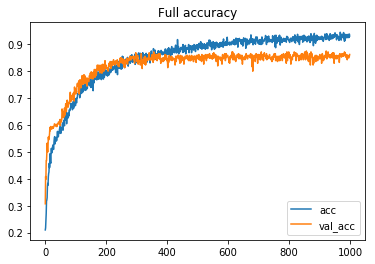

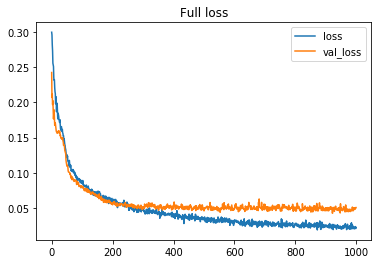

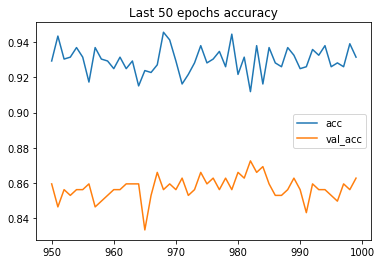

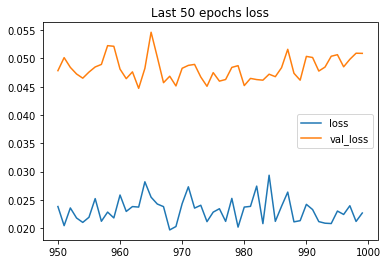

In [22]:
%matplotlib inline

history_df = pd.DataFrame(
    {'acc': history.history['acc'],
     'val_acc': history.history['val_acc'],
     'loss': history.history['loss'],
     'val_loss': history.history['val_loss']
    })

print(history_df.describe())

history_df[['acc', 'val_acc']].plot(title='Full accuracy')
history_df[['loss', 'val_loss']].plot(title='Full loss')
history_df[['acc', 'val_acc']][-50:].plot(title='Last 50 epochs accuracy')
history_df[['loss', 'val_loss']][-50:].plot(title='Last 50 epochs loss')

In [9]:
best_model = keras.models.load_model(PATH_TO_BEST_MODEL)

In [10]:
best_model.evaluate(test_data, test_labels)

306/306 [==============================] - 0s 197us/step


[0.04085408202281185, 0.8856209154222526]

In [11]:
best_model.predict(test_data[0:1])

array([[5.8753788e-25, 1.4461172e-11, 9.9999702e-01, 3.6960277e-09,
        2.9633052e-06]], dtype=float32)